# **Siamese Network**

**Load data:**

In [ ]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)


**Build model CNN**

In [ ]:
# Importing necessary modules and layers from TensorFlow Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Defining input shape for the images
inp = Input(shape = (28,28,1))

# First Convolutional Neural Network block
cnn = Conv2D(filters = 32 , kernel_size = 3 ,activation ='relu')(inp)
cnn = BatchNormalization()(cnn)
pooling = MaxPooling2D(pool_size=(2,2))(cnn)
drop = Dropout(0.2)(pooling)

# Second Convolutional Neural Network block
cnn = Conv2D(filters = 64, kernel_size = 3, activation='relu')(drop)
cnn = BatchNormalization()(cnn)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)
drop = Dropout(0.2)(pooling)

# Third Convolutional Neural Network block
cnn = Conv2D(filters = 128, kernel_size = 3, activation='relu')(drop)
cnn = BatchNormalization()(cnn)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)
drop = Dropout(0.2)(pooling)

# Flattening the output for Dense layers
f = Flatten()(drop)
# First fully connected layer
fc1 = Dense(units = 256, activation ='relu')(f)
# Second fully connected layer
fc2 = Dense(units = 16,activation = 'relu')(fc1)
# Output layer for classification
out = Dense(units = 2)(fc2)

# Creating the CNN model for image feature extraction
cnn = Model(inputs = inp, outputs = out)

# Creating inputs for image pairs
img1 = Input(shape = (28,28,1))
img2 = Input(shape = (28,28,1))

# Obtaining feature vectors for both images using the CNN model
f1 = cnn(img1)
f2 = cnn(img2)

# Calculating the Euclidean distance between the two feature vectors
d = K.sqrt(K.sum(K.square(f1 - f2),axis = 1, keepdims = True))

# Creating the Siamese network model
model = Model(inputs = [img1,img2], outputs = d)

# Printing model summaries
model.summary()  # Summary of the Siamese network model
cnn.summary()    # Summary of the CNN model for image feature extraction

# Custom loss function definitions for model compilation
def loss(y_true, y_pred):
  proba = K.exp(-K.square(y_pred))
  return -K.mean(y_true * K.log(proba) + (1-y_true) * K.log(1-proba))

def loss1(y_true, y_pred):
  return K.mean(y_true * K.square(y_pred) + (1-y_true) * K.square(K.maximum(1.0 - y_pred, 0)))

# Compiling the Siamese network model
model.compile(optimizer = 'adam', loss = loss1)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model_4 (Functional)        (None, 2)                    130738    ['input_9[0][0]',             
                                                                     'input_10[0][0]']            
                                                                                                  
 tf.math.subtract_2 (TFOpLa  (None, 2)                    0         ['model_4[0][0]',       

**Make all pairs or other strategies; some innovation here**

Batch size:  160
(28, 28, 1)
Pair label: 1.0


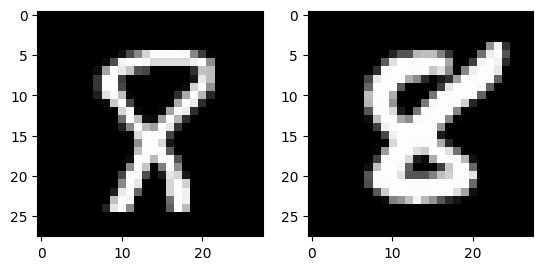

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Generator function to yield batches of image pairs and their labels
def generator(X, y, k=8):
    unique_labels = np.unique(y)

    while True:
        X1 = []  # List to store first images in pairs
        X2 = []  # List to store second images in pairs
        y_batch = []  # List to store corresponding labels
        for label in unique_labels:
            label_idx = np.where(y == label)[0]
            other_labels = set(unique_labels) - {label}

            for i in range(k):
                i1 = np.random.choice(label_idx)
                i2 = np.random.choice(label_idx)

                # i1 must be different from i2 for positive example
                while i1 == i2:
                    i2 = np.random.choice(label_idx)

                # Create positive example
                X1.append(X[i1][:, :, None])  # Append first image
                X2.append(X[i2][:, :, None])  # Append second image
                y_batch.append(1.0)  # Assign label 1 for positive example

                # Create negative example
                i1 = np.random.choice(label_idx)
                my_label = np.random.choice(list(other_labels))
                i2 = np.random.choice(list(np.where(y == my_label)[0]))
                X1.append(X[i1][:, :, None])  # Append first image
                X2.append(X[i2][:, :, None])  # Append second image
                y_batch.append(0.0)  # Assign label 0 for negative example

        yield [np.array(X1) / 255., np.array(X2) / 255.], np.array(y_batch)

# For testing the generator
for pair, y in generator(X_test, y_test):
    print('Batch size: ', len(y))
    idx = np.random.choice(range(len(y)))  # Randomly select an index from the batch
    print(pair[0][idx].shape)
    print('Pair label:', y[idx])
    plt.subplot(121)
    plt.imshow(pair[0][idx].reshape(28, 28), cmap='gray')  # Display first image in pair
    plt.subplot(122)
    plt.imshow(pair[1][idx].reshape(28, 28), cmap='gray')  # Display second image in pair

    break  # Break after the first batch for testing purposes


**Fit model**

In [ ]:
history = model.fit(generator(X_train, y_train, k = 32),
                    steps_per_epoch = 10,
                    epochs = 50,
                    validation_data = generator(X_test, y_test, k = 8),
                    validation_steps = 5)

Epoch 1/50
10/10 [==============================] - 7s 344ms/step - loss: 0.4669 - val_loss: 0.4594
Epoch 2/50
10/10 [==============================] - 3s 332ms/step - loss: 0.2654 - val_loss: 0.4250
Epoch 3/50
10/10 [==============================] - 3s 344ms/step - loss: 0.2353 - val_loss: 0.4201
Epoch 4/50
10/10 [==============================] - 6s 710ms/step - loss: 0.1995 - val_loss: 0.4070
Epoch 5/50
10/10 [==============================] - 3s 358ms/step - loss: 0.1836 - val_loss: 0.3876
Epoch 6/50
10/10 [==============================] - 3s 318ms/step - loss: 0.1793 - val_loss: 0.3740
Epoch 7/50
10/10 [==============================] - 4s 414ms/step - loss: 0.1696 - val_loss: 0.3554
Epoch 8/50
10/10 [==============================] - 4s 466ms/step - loss: 0.1613 - val_loss: 0.3360
Epoch 9/50
10/10 [==============================] - 3s 320ms/step - loss: 0.1539 - val_loss: 0.3181
Epoch 10/50
10/10 [==============================] - 3s 335ms/step - loss: 0.1527 - val_loss: 0.3082

**Visualize learning process**

Text(0, 0.5, 'Loss')

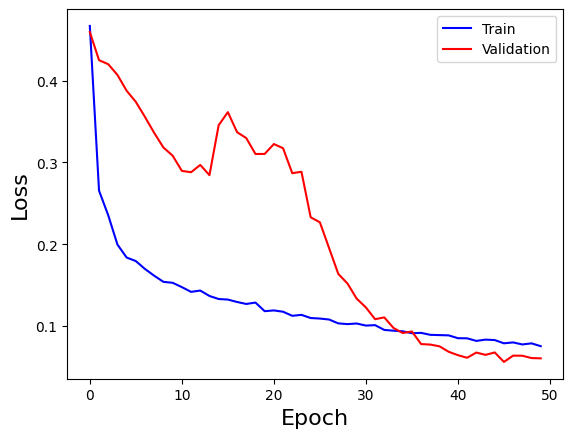

In [ ]:
plt.plot(history.history['loss'], label = 'Train', c = 'b')
plt.plot(history.history['val_loss'], label = 'Validation', c = 'r')
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

5/5 [==============================] - 0s 5ms/step
Batch_size:  160
Pair label: 0.0
Distance: [1.2747759]
Distance by features: [1.2747766]


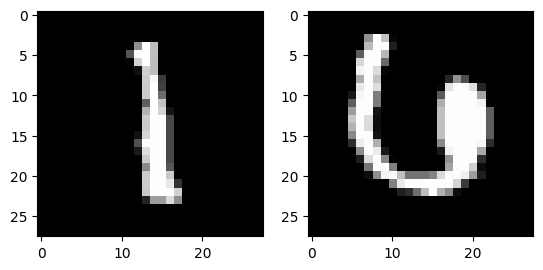

In [ ]:
# Loop for generating predictions and visualizations based on the generator
for pair, y in generator(X_test, y_test):
    # Obtain predictions from the model for the image pairs
    y_pred = model.predict(pair)
    print('Batch_size: ', len(y))
    idx = np.random.choice(range(len(y)))  # Randomly select an index from the batch
    print('Pair label:', y[idx])  # Print label for the selected pair
    print('Distance:', y_pred[idx])  # Print the predicted distance for the pair

    # Extract features for both images in the pair using the CNN model
    f1 = cnn(pair[0])  # Features for the first image
    f2 = cnn(pair[1])  # Features for the second image

    # Calculate distance using the extracted features
    d = np.sqrt(np.sum((f1 - f2) ** 2, axis=1, keepdims=True))
    print('Distance by features:', d[idx])  # Print the distance calculated from features for the pair

    # Visualize the pair of images
    plt.subplot(121)
    plt.imshow(pair[0][idx].reshape(28, 28), cmap='gray')  # Display the first image in the pair
    plt.subplot(122)
    plt.imshow(pair[1][idx].reshape(28, 28), cmap='gray')  # Display the second image in the pair

    break  # Break after processing the first batch for visualization purposes


**Visualize new feature space**

313/313 [==============================] - 1s 3ms/step


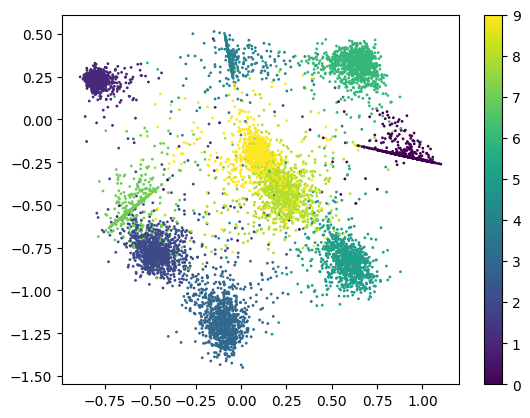

In [ ]:
# Using the CNN model to predict features for the test dataset after normalizing
f = cnn.predict(X_test / 255.)

# Creating a scatter plot to visualize the predicted features
p = plt.scatter(f[:, 0], f[:, 1], c=y_test, s=1)  # Scatter plot with x=f[:,0], y=f[:,1], color=y_test, point size=1
plt.colorbar(p)  # Adding a color bar to represent the classes or labels

**Save model**

In [ ]:
cnn.save('cnn_loss1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Load model and test**

313/313 [==============================] - 1s 2ms/step


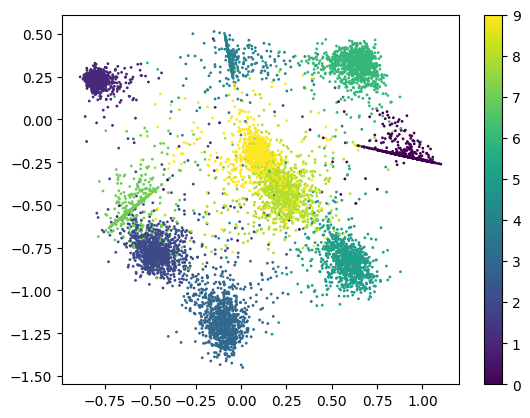

In [ ]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

# Creating a scatter plot to visualize the test features
f1 = m.predict(X_test / 255.)
p = plt.scatter(f1[:,0],f1[:,1],c=y_test,s=1)
plt.colorbar(p)

**Visualize negative distance and positive distance**

In [ ]:
# Initializing variables and lists for storing true and predicted labels
i = 0
y_true = []
y_pred = []

# Looping through the generator to calculate distances and collect labels
for pair, y in generator(X_test, y_test):
    # Extracting features for both images in the pair using the CNN model
    f1 = cnn(pair[0])
    f2 = cnn(pair[1])

    # Calculating distance using the extracted features
    d = np.sqrt(np.sum((f1 - f2) ** 2, axis=1, keepdims=True))

    # Adding calculated distances and true labels to the respective lists
    y_pred += list(d.ravel())  # Storing predicted distances
    y_true += list(y)  # Storing true labels

    i += 1  # Incrementing the iteration counter
    if i > 500:  # Breaking the loop after processing 500 iterations for testing purposes
        break

**Plot histogram**

(array([0.03871327, 0.10859194, 0.17798363, 0.21888825, 0.28219288,
        0.53395097, 0.94640557, 1.50933063, 0.99583195, 0.76525668,
        0.71047375, 0.61429927, 0.48135936, 0.52080246, 0.68223011,
        0.56073374, 0.33064543, 0.22521872, 0.05283509, 0.00292176]),
 array([0.00551254, 0.10798556, 0.21045859, 0.31293163, 0.41540465,
        0.5178777 , 0.62035072, 0.72282374, 0.82529676, 0.92776978,
        1.0302428 , 1.13271582, 1.23518884, 1.33766186, 1.440135  ,
        1.54260802, 1.64508104, 1.74755406, 1.85002708, 1.9525001 ,
        2.05497313]),
 <BarContainer object of 20 artists>)

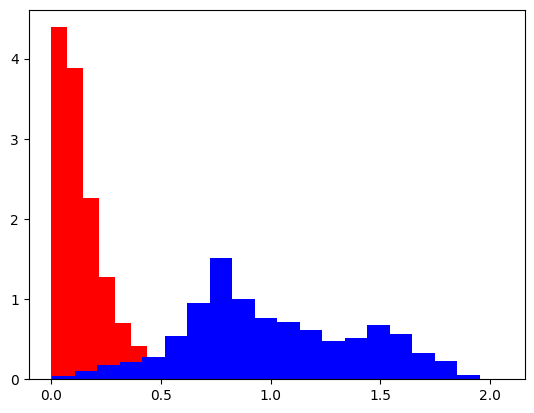

In [ ]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances, color = 'r', density = True, bins = 20)
plt.hist(negative_distances, color = 'b', density = True, bins = 20)

**Check report using sklearn**

In [ ]:
thresh = 0.5
y_pred_ = y_pred < thresh
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     40080
         1.0       0.92      0.96      0.94     40080

    accuracy                           0.94     80160
   macro avg       0.94      0.94      0.94     80160
weighted avg       0.94      0.94      0.94     80160

